# Analysis of proteomics data from October timepoint
Zach Flinkstrom - University of Washington - 2025

In [47]:
# import packages
import pandas as pd
import numpy as np
from statistics import geometric_mean
from scipy.stats import spearmanr, false_discovery_control, kruskal, norm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns
from textwrap import wrap
from statsmodels.stats.multitest import fdrcorrection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from random import sample
from scipy.spatial.distance import pdist, squareform
from skbio.stats import distance, ordination

## Import data and add GTDB taxonomy

In [2]:
# Import proteomics peak height data table
df = pd.read_csv('data/proteomics/peakheights_w_gene_tax_info.csv', index_col=0)
df.drop('Unnamed: 14', axis=1, inplace=True)
df.head()

,TOP2,TOP3,TOP4,MID2,MID3,MID4,BTM2,BTM3,BTM4,Gene_Product,Ortholog_ID,percent_id,taxonomy
IDs,,,,,,,,,,,,,
Ga0562388_13581230_3_440,391432000.0,299568.0,192505060.0,266925300.0,8.078859e+08,535531100.0,305932490.0,421714397.0,21550708.0,methyl-coenzyme M reductase beta subunit,KO:K00401,89.57,Archaea;Euryarchaeota;Methanomicrobia;Methanos...
Ga0562388_01581740_69_1484,612399060.0,42993410.0,153243799.0,39273640.0,1.121121e+09,284543240.0,381349362.0,102749738.0,369720644.0,predicted porin,COG3203,43.51,Bacteria;Proteobacteria;Betaproteobacteria;Rho...
Ga0562388_00729613_1631_2773,194004000.0,319361638.0,44454100.0,972623530.0,2.086457e+08,158431490.0,198677102.0,10084330.0,312564457.0,predicted porin,COG3203,38.11,Bacteria;Proteobacteria;Betaproteobacteria;Bur...
Ga0562388_00005606_10996_12147,329773509.0,150035970.0,168129252.0,331881520.0,4.509542e+08,254710350.0,21366040.0,62589435.0,28185790.0,predicted porin,COG3203,42.93,Bacteria;Proteobacteria;Betaproteobacteria;Nit...
Ga0562388_24204085_1_414,44386880.0,145270000.0,158061800.0,998325000.0,3.633424e+08,581392900.0,0.0,0.0,0.0,predicted porin,COG3203,35.34,Bacteria;Proteobacteria;Betaproteobacteria;Nei...


In [3]:
# Split ncbi taxonomy into different levels
df['taxonomy'] = df['taxonomy'].fillna('Unidentified')
split_tax = df['taxonomy'].str.split(';', expand=True)
split_tax = split_tax.rename(columns={0:'ncbi_domain',1:'ncbi_phylum',2:'ncbi_class',3:'ncbi_order',4:'ncbi_family',5:'ncbi_genus',6:'ncbi_species',7:'ncbi_strain'})
df = pd.concat([df,split_tax], axis=1)
df

,TOP2,TOP3,TOP4,MID2,MID3,MID4,BTM2,BTM3,BTM4,Gene_Product,...,percent_id,taxonomy,ncbi_domain,ncbi_phylum,ncbi_class,ncbi_order,ncbi_family,ncbi_genus,ncbi_species,ncbi_strain
IDs,,,,,,,,,,,,,,,,,,,,,
Ga0562388_13581230_3_440,391432000.0,299568.0,192505060.0,266925300.0,8.078859e+08,5.355311e+08,3.059325e+08,421714397.0,2.155071e+07,methyl-coenzyme M reductase beta subunit,...,89.57,Archaea;Euryarchaeota;Methanomicrobia;Methanos...,Archaea,Euryarchaeota,Methanomicrobia,Methanosarcinales,Methanotrichaceae,Methanothrix,Methanothrix soehngenii,Methanothrix soehngenii GP-6
Ga0562388_01581740_69_1484,612399060.0,42993410.0,153243799.0,39273640.0,1.121121e+09,2.845432e+08,3.813494e+08,102749738.0,3.697206e+08,predicted porin,...,43.51,Bacteria;Proteobacteria;Betaproteobacteria;Rho...,Bacteria,Proteobacteria,Betaproteobacteria,Rhodocyclales,Zoogloeaceae,Zoogloea,Zoogloea sp. LCSB751,Zoogloea schifflangensis LCSB751
Ga0562388_00729613_1631_2773,194004000.0,319361638.0,44454100.0,972623530.0,2.086457e+08,1.584315e+08,1.986771e+08,10084330.0,3.125645e+08,predicted porin,...,38.11,Bacteria;Proteobacteria;Betaproteobacteria;Bur...,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Burkholderiaceae,Quisquiliibacterium,Quisquiliibacterium transsilvanicum,Quisquiliibacterium transsilvanicum DSM 29781
Ga0562388_00005606_10996_12147,329773509.0,150035970.0,168129252.0,331881520.0,4.509542e+08,2.547104e+08,2.136604e+07,62589435.0,2.818579e+07,predicted porin,...,42.93,Bacteria;Proteobacteria;Betaproteobacteria;Nit...,Bacteria,Proteobacteria,Betaproteobacteria,Nitrosomonadales,Thiobacillaceae,Sulfuritortus,Sulfuritortus calidifontis,Sulfuritortus calidifontis DSM 103923
Ga0562388_24204085_1_414,44386880.0,145270000.0,158061800.0,998325000.0,3.633424e+08,5.813929e+08,0.000000e+00,0.0,0.000000e+00,predicted porin,...,35.34,Bacteria;Proteobacteria;Betaproteobacteria;Nei...,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Chromobacteriaceae,Chitinilyticum,Chitinilyticum litopenaei,Chitinilyticum litopenaei DSM 21440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ga0562388_04202411_662_1177,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,77867300.0,7.719920e+07,tetratricopeptide (TPR) repeat protein,...,46.48,Bacteria;Proteobacteria;Deltaproteobacteria;Sy...,Bacteria,Proteobacteria,Deltaproteobacteria,Syntrophobacterales,Syntrophaceae,Desulfobacca,Desulfobacca acetoxidans,Desulfobacca acetoxidans ASRB2- DSM 11109
Ga0562388_15035897_553_693,67132200.0,0.0,0.0,0.0,8.756570e+07,0.000000e+00,8.664400e+07,112554000.0,0.000000e+00,5-6-7-8-tetrahydromethanopterin hydro-lyase,...,91.49,Bacteria;Proteobacteria;Alphaproteobacteria;Hy...,Bacteria,Proteobacteria,Alphaproteobacteria,Hyphomicrobiales,Hyphomicrobiaceae,Hyphomicrobium,Hyphomicrobium facile,Hyphomicrobium facile facile DSM 1565
Ga0562388_00710651_281_1912,0.0,21414900.0,0.0,0.0,1.754950e+08,0.000000e+00,1.016510e+08,0.0,1.004760e+08,chaperonin GroEL,...,78.11,Bacteria;Proteobacteria;Deltaproteobacteria;My...,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,Sandaracinus,Sandaracinus amylolyticus,Sandaracinus amylolyticus DSM 53668


In [4]:
#Reformat taxonomy to be compatible with GTDB style
new_tax = []
letters = ['d__',';p__',';c__',';o__',';f__',';g__']
for i in df.taxonomy:
    new_format = ''
    for j,k in enumerate(i.split(';')[0:-2]):
        new_format += letters[j] + k
    new_tax.append(new_format)
df['ncbi_tax'] = new_tax
df.head()

,TOP2,TOP3,TOP4,MID2,MID3,MID4,BTM2,BTM3,BTM4,Gene_Product,...,taxonomy,ncbi_domain,ncbi_phylum,ncbi_class,ncbi_order,ncbi_family,ncbi_genus,ncbi_species,ncbi_strain,ncbi_tax
IDs,,,,,,,,,,,,,,,,,,,,,
Ga0562388_13581230_3_440,391432000.0,299568.0,192505060.0,266925300.0,8.078859e+08,535531100.0,305932490.0,421714397.0,21550708.0,methyl-coenzyme M reductase beta subunit,...,Archaea;Euryarchaeota;Methanomicrobia;Methanos...,Archaea,Euryarchaeota,Methanomicrobia,Methanosarcinales,Methanotrichaceae,Methanothrix,Methanothrix soehngenii,Methanothrix soehngenii GP-6,d__Archaea;p__Euryarchaeota;c__Methanomicrobia...
Ga0562388_01581740_69_1484,612399060.0,42993410.0,153243799.0,39273640.0,1.121121e+09,284543240.0,381349362.0,102749738.0,369720644.0,predicted porin,...,Bacteria;Proteobacteria;Betaproteobacteria;Rho...,Bacteria,Proteobacteria,Betaproteobacteria,Rhodocyclales,Zoogloeaceae,Zoogloea,Zoogloea sp. LCSB751,Zoogloea schifflangensis LCSB751,d__Bacteria;p__Proteobacteria;c__Betaproteobac...
Ga0562388_00729613_1631_2773,194004000.0,319361638.0,44454100.0,972623530.0,2.086457e+08,158431490.0,198677102.0,10084330.0,312564457.0,predicted porin,...,Bacteria;Proteobacteria;Betaproteobacteria;Bur...,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Burkholderiaceae,Quisquiliibacterium,Quisquiliibacterium transsilvanicum,Quisquiliibacterium transsilvanicum DSM 29781,d__Bacteria;p__Proteobacteria;c__Betaproteobac...
Ga0562388_00005606_10996_12147,329773509.0,150035970.0,168129252.0,331881520.0,4.509542e+08,254710350.0,21366040.0,62589435.0,28185790.0,predicted porin,...,Bacteria;Proteobacteria;Betaproteobacteria;Nit...,Bacteria,Proteobacteria,Betaproteobacteria,Nitrosomonadales,Thiobacillaceae,Sulfuritortus,Sulfuritortus calidifontis,Sulfuritortus calidifontis DSM 103923,d__Bacteria;p__Proteobacteria;c__Betaproteobac...
Ga0562388_24204085_1_414,44386880.0,145270000.0,158061800.0,998325000.0,3.633424e+08,581392900.0,0.0,0.0,0.0,predicted porin,...,Bacteria;Proteobacteria;Betaproteobacteria;Nei...,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Chromobacteriaceae,Chitinilyticum,Chitinilyticum litopenaei,Chitinilyticum litopenaei DSM 21440,d__Bacteria;p__Proteobacteria;c__Betaproteobac...


In [5]:
#Load GTDB taxonomy info and map to ncbi
ar53 = pd.read_csv('data/ar53_metadata_r214.tsv', sep='\t', usecols=['gtdb_taxonomy','ncbi_taxonomy'])
bac120 = pd.read_csv('data/bac120_metadata_r214.tsv', sep='\t', usecols=['gtdb_taxonomy','ncbi_taxonomy'])
gtdb_tax = pd.concat([ar53, bac120])
gtdb_tax['gtdb_taxonomy'] = gtdb_tax['gtdb_taxonomy'].str.split(';s__', expand=True)[0]
gtdb_tax['ncbi_taxonomy'] = gtdb_tax['ncbi_taxonomy'].str.split(';s__', expand=True)[0].str.split(';g__', expand=True)[1]
gtdb_tax = gtdb_tax.drop_duplicates()

# Create mapper function for entries at the genus level
ncbi_genus = list(set(df.ncbi_genus))
gtdb_mapper = {'Dechloromonas':'d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae;g__Azonexus'}#manual intervention for dechloromonas due to name change
for g in ncbi_genus:
    if g is not None:
        if (gtdb_tax.gtdb_taxonomy.str.contains(g).sum()>0):
            gtdb_mapper[g] = list(gtdb_tax[gtdb_tax.gtdb_taxonomy.str.contains(g)].gtdb_taxonomy)[0]
# Create mapper function for entries at the family level
ncbi_family = list(set(df.ncbi_family))
gtdb_mapper2 = {}
for g in ncbi_family:
    if g is not None:
        if (gtdb_tax.gtdb_taxonomy.str.contains(g).sum()>0):
            gtdb_mapper2[g] = list(gtdb_tax[gtdb_tax.gtdb_taxonomy.str.contains(g)].gtdb_taxonomy)[0]
# Create mapper function for entries at the order level
ncbi_order = list(set(df.ncbi_order))
gtdb_mapper3 = {}
for g in ncbi_order:
    if g is not None:
        if (gtdb_tax.gtdb_taxonomy.str.contains(g).sum()>0):
            gtdb_mapper3[g] = list(gtdb_tax[gtdb_tax.gtdb_taxonomy.str.contains(g)].gtdb_taxonomy)[0]


# Apply the mapper functions to create a new gtdb taxonomy column
df['gtdb_tax'] = df.apply(lambda row: gtdb_mapper.get(row["ncbi_genus"], gtdb_mapper2.get(row["ncbi_family"], gtdb_mapper3.get(row["ncbi_order"], row["ncbi_tax"]))), axis=1) #map to gtdb taxonomy, default to ncbi if no match exists
gtdb_split_tax = df['gtdb_tax'].str.split(';', expand=True)
gtdb_split_tax = gtdb_split_tax.rename(columns={0:'gtdb_domain',1:'gtdb_phylum',2:'gtdb_class',3:'gtdb_order',4:'gtdb_family',5:'gtdb_genus'})
df = pd.concat([df,gtdb_split_tax], axis=1)

df.head()

,TOP2,TOP3,TOP4,MID2,MID3,MID4,BTM2,BTM3,BTM4,Gene_Product,...,ncbi_species,ncbi_strain,ncbi_tax,gtdb_tax,gtdb_domain,gtdb_phylum,gtdb_class,gtdb_order,gtdb_family,gtdb_genus
IDs,,,,,,,,,,,,,,,,,,,,,
Ga0562388_13581230_3_440,391432000.0,299568.0,192505060.0,266925300.0,8.078859e+08,535531100.0,305932490.0,421714397.0,21550708.0,methyl-coenzyme M reductase beta subunit,...,Methanothrix soehngenii,Methanothrix soehngenii GP-6,d__Archaea;p__Euryarchaeota;c__Methanomicrobia...,d__Archaea;p__Halobacteriota;c__Methanosarcini...,d__Archaea,p__Halobacteriota,c__Methanosarcinia,o__Methanotrichales,f__Methanotrichaceae,g__Methanothrix_A
Ga0562388_01581740_69_1484,612399060.0,42993410.0,153243799.0,39273640.0,1.121121e+09,284543240.0,381349362.0,102749738.0,369720644.0,predicted porin,...,Zoogloea sp. LCSB751,Zoogloea schifflangensis LCSB751,d__Bacteria;p__Proteobacteria;c__Betaproteobac...,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,d__Bacteria,p__Pseudomonadota,c__Gammaproteobacteria,o__Burkholderiales,f__Rhodocyclaceae,g__Zoogloea
Ga0562388_00729613_1631_2773,194004000.0,319361638.0,44454100.0,972623530.0,2.086457e+08,158431490.0,198677102.0,10084330.0,312564457.0,predicted porin,...,Quisquiliibacterium transsilvanicum,Quisquiliibacterium transsilvanicum DSM 29781,d__Bacteria;p__Proteobacteria;c__Betaproteobac...,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,d__Bacteria,p__Pseudomonadota,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae_A,g__Quisquiliibacterium
Ga0562388_00005606_10996_12147,329773509.0,150035970.0,168129252.0,331881520.0,4.509542e+08,254710350.0,21366040.0,62589435.0,28185790.0,predicted porin,...,Sulfuritortus calidifontis,Sulfuritortus calidifontis DSM 103923,d__Bacteria;p__Proteobacteria;c__Betaproteobac...,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,d__Bacteria,p__Pseudomonadota,c__Gammaproteobacteria,o__Burkholderiales,f__Thiobacillaceae,g__Sulfuritortus
Ga0562388_24204085_1_414,44386880.0,145270000.0,158061800.0,998325000.0,3.633424e+08,581392900.0,0.0,0.0,0.0,predicted porin,...,Chitinilyticum litopenaei,Chitinilyticum litopenaei DSM 21440,d__Bacteria;p__Proteobacteria;c__Betaproteobac...,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,d__Bacteria,p__Pseudomonadota,c__Gammaproteobacteria,o__Burkholderiales,f__Chitinibacteraceae,g__Chitinilyticum


In [6]:
# add data summary columns
df['gene-tax'] = df['Gene_Product']+':'+df['gtdb_order']
df['gtdb_order_class'] = df['gtdb_class'].str.split('c__',expand=True)[1]+';'+df['gtdb_order'].str.split('o__',expand=True)[1]

df['mean'] = df.iloc[:,0:9].mean(axis=1)
df['median'] = df.iloc[:,0:9].median(axis=1)
df['min'] = df.iloc[:,0:9].min(axis=1)
df['max'] = df.iloc[:,0:9].max(axis=1)
df['sum'] = df.iloc[:,0:9].sum(axis=1)

In [7]:
df = df[df['max']>0] # filter out proteins with zero peak heights across samples

In [8]:
def impute_zeros_with_gaussian(df, std_fraction=0.1):
    """Function to impute zeros by sampling from a normal distribution
        centered around the minimum peak height in the sample."""
    df_imputed = df.copy()
    for col in df.columns:
        non_zero_vals = df[col][df[col] != 0]
        if not non_zero_vals.empty:
            min_val = non_zero_vals.min()
            std_dev = std_fraction * min_val
            num_zeros = (df[col] == 0).sum()
            sampled_values = np.random.normal(loc=min_val, scale=std_dev, size=num_zeros)
            # Ensure no negative values
            sampled_values = np.clip(sampled_values, a_min=0, a_max=None)
            df_imputed.loc[df[col] == 0, col] = sampled_values
    return df_imputed


In [9]:
def impute_add_stats(in_df, num_permutations=100):
    """Function to add kruskal wallis and Spearman correlation statistics to the 
        input dataframe. Uses permutation testing to estimate correlation p-values"""
    df_imputed = impute_zeros_with_gaussian(in_df)
    df_imputed = df_imputed/df_imputed.sum(axis=0) # Normalize
    rs = []
    for i in df_imputed.index:
        res = spearmanr([10,10,10,30,30,30,50,50,50], df_imputed.loc[i][0:9])
        rs.append(res.statistic)
        
    # Permutation testing
    random_r = []
    for j in range(num_permutations):
        for i in range(len(df_imputed.index)):
            random_depths = sample([10,10,10,30,30,30,50,50,50], 9)
            random_r.append(spearmanr(random_depths, df_imputed.iloc[i,0:9], alternative = 'two-sided').correlation)
    mu = np.mean(random_r)
    sigma = np.std(random_r)
    p_vals = []
    for i in rs:
        z = (i - mu)/sigma
        p = norm.sf(abs(z))*2
        p_vals.append(p)
        
    #Create dataframe columns
    df_imputed['spearman_r'] = rs
    df_imputed['spearman_p'] = p_vals
    df_imputed['spearman_p_corr'] = fdrcorrection(p_vals, alpha=0.05)[1]
    # Kruskal-Wallis test
    kruskal_pval = kruskal(df_imputed[['TOP2','TOP3','TOP4']],df_imputed[['MID2','MID3','MID4']],df_imputed[['BTM2','BTM3','BTM4']], axis=1).pvalue
    df_imputed['kruskal_p'] = kruskal_pval
    df_imputed['kruskal_p_corr'] = fdrcorrection(kruskal_pval, alpha=0.05)[1]
    df_imputed['median'] = df_imputed.iloc[:,0:9].median(axis=1)
    return df_imputed

## Plot order-level proteomic abundance

In [30]:
gene_tax_df = df.groupby('gtdb_order_class').sum().iloc[:,0:9] #add up peak heights for each gene-taxa combo across samples
gene_tax_df[gene_tax_df < 1.] = 0. #replace near-zero values with 0

df_imputed = impute_add_stats(gene_tax_df)

In [11]:
df_imputed.sort_values('median', ascending=False).head(20)

,TOP2,TOP3,TOP4,MID2,MID3,MID4,BTM2,BTM3,BTM4,spearman_r,spearman_p,spearman_p_corr,kruskal_p,kruskal_p_corr,median
gtdb_order_class,,,,,,,,,,,,,,,
Gammaproteobacteria;Burkholderiales,0.271596,0.285453,0.283260,0.271928,0.323617,0.276249,0.153004,0.149648,0.154330,-0.685160,0.053793,0.561461,0.066463,0.741970,0.271928
Methanosarcinia;Methanotrichales,0.095867,0.062717,0.075676,0.083093,0.081968,0.061699,0.134244,0.142032,0.111435,0.685160,0.050767,0.561461,0.066463,0.741970,0.083093
Gammaproteobacteria;Methylococcales,0.037054,0.078483,0.074166,0.070577,0.034597,0.028806,0.071960,0.057726,0.050810,-0.210819,0.558717,0.869115,0.252138,0.770010,0.057726
Syntrophobacteria;Syntrophobacterales,0.032557,0.069599,0.050008,0.052032,0.061040,0.057394,0.040687,0.038827,0.026949,-0.421637,0.237217,0.741935,0.147916,0.741970,0.050008
Alphaproteobacteria;Rhizobiales,0.079957,0.042949,0.044860,0.031278,0.050588,0.044164,0.049901,0.107650,0.066704,0.368932,0.290233,0.764807,0.252138,0.770010,0.049901
Methanomicrobia;Methanomicrobiales,0.048050,0.048592,0.037226,0.037563,0.030947,0.047133,0.048910,0.064430,0.103008,0.579751,0.097959,0.561461,0.050906,0.741970,0.048050
Desulfobaccia;Desulfobaccales,0.025358,0.035691,0.033646,0.023279,0.034902,0.036930,0.034111,0.047641,0.024976,0.105409,0.755737,0.903901,0.956529,0.959793,0.034111
Desulfobacteria;Desulfobacterales,0.030630,0.015424,0.018764,0.020771,0.027731,0.023248,0.023162,0.018926,0.020292,0.052705,0.871481,0.935721,0.429796,0.810000,0.020771
DSM-4660;Desulfatiglandales,0.008786,0.020907,0.019000,0.021680,0.018942,0.022504,0.016412,0.015299,0.009548,-0.263523,0.462916,0.810102,0.147916,0.741970,0.018942


In [12]:
df_imputed.sort_values('spearman_r', ascending=True)

,TOP2,TOP3,TOP4,MID2,MID3,MID4,BTM2,BTM3,BTM4,spearman_r,spearman_p,spearman_p_corr,kruskal_p,kruskal_p_corr,median
gtdb_order_class,,,,,,,,,,,,,,,
Coscinodiscophyceae;Thalassiosirales,0.000851,0.000580,0.001922,0.000345,0.000577,0.000312,0.000103,0.000331,0.000195,-0.895979,0.011546,0.561461,0.038990,0.74197,0.000345
Gammaproteobacteria;Thiohalobacterales,0.002214,0.000648,0.002189,0.000343,0.000776,0.000610,0.000075,0.000364,0.000003,-0.843274,0.017482,0.561461,0.058167,0.74197,0.000610
Chthonomonadetes;Chthonomonadales,0.000004,0.000004,0.000322,0.000003,0.000004,0.000006,0.000003,0.000004,0.000003,-0.790569,0.025940,0.561461,0.079394,0.74197,0.000004
Betaproteobacteria;unclassified Betaproteobacteria,0.020227,0.016129,0.009311,0.032372,0.010065,0.009295,0.007094,0.004767,0.008086,-0.737865,0.037728,0.561461,0.066463,0.74197,0.009311
Cyanobacteriia;Cyanobacteriales,0.000452,0.001851,0.000937,0.000550,0.000381,0.001697,0.000421,0.000149,0.000364,-0.737865,0.037728,0.561461,0.099151,0.74197,0.000452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Eumycetozoa;Dictyosteliales,0.000005,0.000152,0.000003,0.000309,0.000294,0.000007,0.000768,0.000233,0.000446,0.790569,0.024319,0.561461,0.079394,0.74197,0.000233
Magnoliopsida;Malpighiales,0.001571,0.001152,0.000806,0.003381,0.002457,0.001602,0.003254,0.001656,0.004058,0.790569,0.024319,0.561461,0.060810,0.74197,0.001656
Gammaproteobacteria;Diplorickettsiales,0.000004,0.000004,0.000229,0.000053,0.000112,0.001124,0.000496,0.002996,0.002916,0.790569,0.024319,0.561461,0.079394,0.74197,0.000229


In [13]:
to_plot = df_imputed.sort_values('median', ascending=False).head(20).iloc[:,0:9]
to_plot_long = to_plot.reset_index().melt(id_vars='gtdb_order_class',var_name='Sample',value_name='Normalized_Peak_Height')
to_plot_long['Depth'] = to_plot_long['Sample'].apply(lambda x:{'TOP':'0-20cm','MID':'20-40cm','BTM':'40-60cm'}[x[0:3]])
to_plot_long

,gtdb_order_class,Sample,Normalized_Peak_Height,Depth
0,Gammaproteobacteria;Burkholderiales,TOP2,0.271596,0-20cm
1,Methanosarcinia;Methanotrichales,TOP2,0.095867,0-20cm
2,Gammaproteobacteria;Methylococcales,TOP2,0.037054,0-20cm
3,Syntrophobacteria;Syntrophobacterales,TOP2,0.032557,0-20cm
4,Alphaproteobacteria;Rhizobiales,TOP2,0.079957,0-20cm
...,...,...,...,...
175,Syntrophorhabdia;Syntrophorhabdales,BTM4,0.007593,40-60cm
176,Desulfobulbia;Desulfobulbales,BTM4,0.006354,40-60cm
177,Gammaproteobacteria;Chromatiales,BTM4,0.014851,40-60cm
178,Alphaproteobacteria;Sphingomonadales,BTM4,0.003455,40-60cm


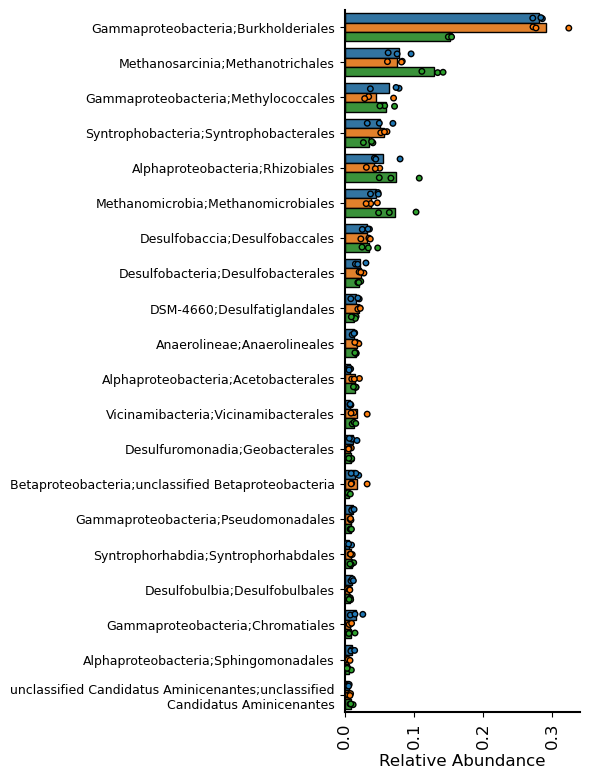

In [14]:
fig, ax = plt.subplots(1,1, figsize=(6, 8))
g = sns.stripplot(data=to_plot_long, y='gtdb_order_class', x='Normalized_Peak_Height', hue='Depth', hue_order=['0-20cm','20-40cm','40-60cm'], dodge=True, edgecolor='black', linewidth=1, jitter=True, size=4, legend=None)
g = sns.barplot(data=to_plot_long, y='gtdb_order_class', x='Normalized_Peak_Height', hue='Depth', hue_order=['0-20cm','20-40cm','40-60cm'], dodge=True, edgecolor='black', linewidth=1., errorbar=None, legend=None)

sns.despine()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

labels = ['\n'.join(wrap(x, 50)) for x in  to_plot_long.gtdb_order_class.drop_duplicates()]
plt.yticks(np.arange(0,20), labels, fontsize=9)

plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Relative Abundance', size=12)
plt.ylabel('')
plt.tight_layout()
plt.savefig('figures/proteomics_order_abundance.svg', bbox_inches='tight')
plt.show()

### Distance-based analysis of order-level proteomic data

In [34]:
# Calculate distance matrix
dist = pdist(df_imputed.iloc[:,0:9].T, metric='Euclidean')
square_dist = squareform(dist)
dist_mat = distance.DistanceMatrix(square_dist, ids=df_imputed.iloc[:,0:9].columns)

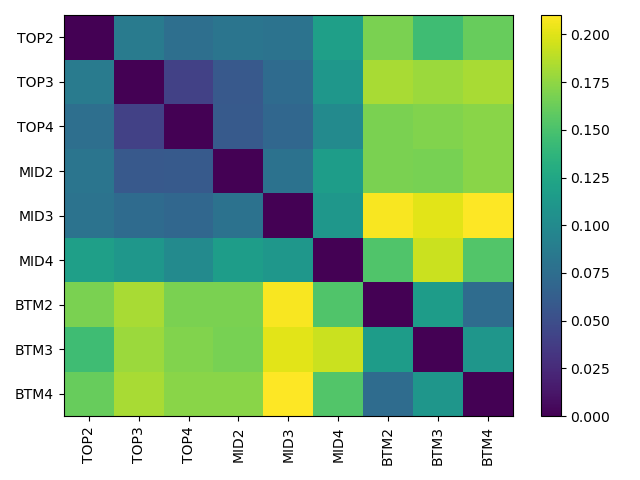

In [35]:
dist_mat

In [37]:
distance.permanova(dist_mat, ['Top','Top','Top','Mid','Mid','Mid','Btm','Btm','Btm'], permutations=99999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                       9
number of groups                  3
test statistic             6.020899
p-value                      0.0316
number of permutations        99999
Name: PERMANOVA results, dtype: object

In [38]:
distance.anosim(dist_mat, ['Top','Top','Top','Mid','Mid','Mid','Btm','Btm','Btm'], permutations=99999)

method name                 ANOSIM
test statistic name              R
sample size                      9
number of groups                 3
test statistic            0.596708
p-value                    0.03551
number of permutations       99999
Name: ANOSIM results, dtype: object

In [42]:
# Compute PCoA
pcoa = ordination.pcoa(dist_mat)
pcoa_plot = pcoa.samples.copy()
pcoa_plot['depth'] = ['Top','Top','Top','Mid','Mid','Mid','Btm','Btm','Btm']

In [43]:
def confidence_ellipse(x, y, ax, n_std=1.5, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

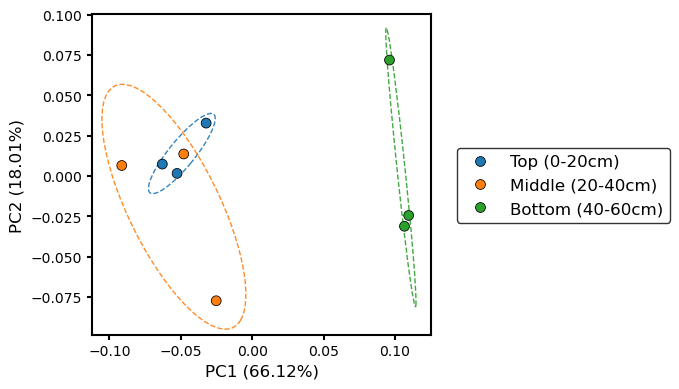

In [50]:
# Plot PCoA of proteomic order abundance colored by depth
fig, ax = plt.subplots(1,1, figsize=(7, 4))

confidence_ellipse(pcoa_plot[pcoa_plot.depth=='Top']['PC1'], pcoa_plot[pcoa_plot.depth=='Top']['PC2'], ax, edgecolor='tab:blue', linestyle='--', alpha=0.9)
confidence_ellipse(pcoa_plot[pcoa_plot.depth=='Mid']['PC1'], pcoa_plot[pcoa_plot.depth=='Mid']['PC2'], ax, edgecolor='tab:orange', linestyle='--', alpha=0.9)
confidence_ellipse(pcoa_plot[pcoa_plot.depth=='Btm']['PC1'], pcoa_plot[pcoa_plot.depth=='Btm']['PC2'], ax, edgecolor='tab:green', linestyle='--', alpha=0.9)
sns.scatterplot(data=pcoa_plot, x='PC1', y='PC2', hue='depth', s=50, edgecolor='black', hue_order=['Top','Mid','Btm'], ax=ax)

ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)

ax.legend(handles = ax.get_legend_handles_labels()[0][0:3],
          labels=['Top (0-20cm)', 'Middle (20-40cm)', 'Bottom (40-60cm)'],
          fontsize=12, title_fontsize=12, edgecolor='black', bbox_to_anchor=(1.05, 0.61))

ax.tick_params(width=1.5)
plt.xticks(size=10)
plt.yticks(fontsize=10)
plt.xlabel('PC1 ({:.2f}%)'.format(pcoa.proportion_explained.iloc[0]*100), size=12)
plt.ylabel('PC2 ({:.2f}%)'.format(pcoa.proportion_explained.iloc[1]*100), size=12)
plt.tight_layout()
plt.savefig('figures/proteomics_order_pcoa.png', dpi=450)
plt.show()

## Plot protein product abundance

In [51]:
gene_tax_df = df.groupby('Gene_Product').sum().iloc[:,0:9] #add up peak heights for each gene-taxa combo across samples
gene_tax_df[gene_tax_df < 1.] = 0. #replace near-zero values with 0
gene_tax_df = gene_tax_df.drop('hypothetical protein')
df_imputed = impute_add_stats(gene_tax_df)

In [16]:
df_imputed.sort_values('median', ascending=False).head(20)

,TOP2,TOP3,TOP4,MID2,MID3,MID4,BTM2,BTM3,BTM4,spearman_r,spearman_p,spearman_p_corr,kruskal_p,kruskal_p_corr,median
Gene_Product,,,,,,,,,,,,,,,
predicted porin,0.215279,0.212955,0.196471,0.198433,0.211471,0.209544,0.164391,0.138454,0.189937,-0.790569,0.025737,0.290338,0.060810,0.455441,0.198433
chaperonin GroEL,0.167184,0.102895,0.144829,0.143368,0.129034,0.108545,0.118729,0.070538,0.095430,-0.632456,0.074453,0.290338,0.176694,0.455441,0.118729
methyl-coenzyme M reductase beta subunit,0.069500,0.036207,0.036425,0.054451,0.051120,0.042728,0.090222,0.099192,0.063158,0.685160,0.052914,0.290338,0.113293,0.455441,0.054451
methane/ammonia monooxygenase subunit B,0.031309,0.064669,0.071824,0.068629,0.027148,0.031484,0.052247,0.079758,0.042413,0.105409,0.764888,0.831066,0.561144,0.694595,0.052247
adenylylsulfate reductase subunit A,0.017340,0.040943,0.034356,0.032888,0.027101,0.047759,0.031623,0.012447,0.023200,-0.421637,0.234554,0.394746,0.288101,0.503940,0.031623
S-layer protein (TIGR01567 family),0.025614,0.021227,0.024234,0.017034,0.019872,0.011106,0.049337,0.026383,0.029274,0.474342,0.180079,0.344991,0.027324,0.455441,0.024234
methyl-coenzyme M reductase gamma subunit,0.014809,0.007152,0.012813,0.008671,0.010581,0.027987,0.023065,0.034254,0.061290,0.685160,0.052914,0.290338,0.113293,0.455441,0.014809
OOP family OmpA-OmpF porin,0.014624,0.016163,0.024054,0.010137,0.012083,0.014543,0.016004,0.021548,0.014762,-0.052705,0.882923,0.901511,0.066463,0.455441,0.014762
elongation factor Tu,0.018651,0.013785,0.010121,0.016175,0.018428,0.014633,0.019553,0.012616,0.009672,-0.052705,0.882923,0.901511,0.732632,0.805066,0.014633


In [17]:
df_imputed.sort_values('spearman_r', ascending=False)

,TOP2,TOP3,TOP4,MID2,MID3,MID4,BTM2,BTM3,BTM4,spearman_r,spearman_p,spearman_p_corr,kruskal_p,kruskal_p_corr,median
Gene_Product,,,,,,,,,,,,,,,
methanol corrinoid protein,0.001280,0.004351,0.001867,0.004440,0.002758,0.004600,9.069070e-03,0.005400,1.310699e-02,0.895979,0.011382,0.290338,0.038990,0.455441,0.004440
large subunit ribosomal protein L6,0.000069,0.000093,0.000078,0.000128,0.000471,0.000225,7.436792e-04,0.000252,2.375956e-04,0.843274,0.017221,0.290338,0.050906,0.455441,0.000225
uncharacterized membrane protein YheB (UPF0754 family),0.000002,0.000005,0.000005,0.000003,0.000038,0.000019,5.442412e-05,0.000040,2.512886e-04,0.843274,0.017221,0.290338,0.050906,0.455441,0.000019
D-xylose transport system substrate-binding protein,0.002162,0.002029,0.003046,0.002240,0.003170,0.002445,8.856759e-03,0.011362,9.977782e-03,0.843274,0.017221,0.290338,0.050906,0.455441,0.003046
spore coat protein A,0.001003,0.001050,0.001167,0.001791,0.001814,0.001234,2.947191e-03,0.001847,1.286292e-03,0.843274,0.017221,0.290338,0.050906,0.455441,0.001286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NADP-reducing hydrogenase subunit HndA,0.000109,0.000005,0.000006,0.000003,0.000004,0.000002,9.468086e-07,0.000004,6.963487e-07,-0.843274,0.017363,0.290338,0.050906,0.455441,0.000004
host factor-I protein,0.000287,0.000214,0.001000,0.000003,0.000019,0.000099,9.864771e-07,0.000004,6.484242e-07,-0.895979,0.011481,0.290338,0.038990,0.455441,0.000019
sugar lactone lactonase YvrE,0.000273,0.000004,0.000005,0.000003,0.000004,0.000002,1.003390e-06,0.000003,5.966754e-07,-0.895979,0.011481,0.290338,0.038990,0.455441,0.000003


In [18]:
to_plot = df_imputed.sort_values('median', ascending=False).head(20).iloc[:,0:9]
to_plot_long = to_plot.reset_index().melt(id_vars='Gene_Product',var_name='Sample',value_name='Normalized_Peak_Height')
to_plot_long['Depth'] = to_plot_long['Sample'].apply(lambda x:{'TOP':'0-20cm','MID':'20-40cm','BTM':'40-60cm'}[x[0:3]])
to_plot_long

,Gene_Product,Sample,Normalized_Peak_Height,Depth
0,predicted porin,TOP2,0.215279,0-20cm
1,chaperonin GroEL,TOP2,0.167184,0-20cm
2,methyl-coenzyme M reductase beta subunit,TOP2,0.069500,0-20cm
3,methane/ammonia monooxygenase subunit B,TOP2,0.031309,0-20cm
4,adenylylsulfate reductase subunit A,TOP2,0.017340,0-20cm
...,...,...,...,...
175,F-type H+-transporting ATPase subunit alpha,BTM4,0.006467,40-60cm
176,F-type H+-transporting ATPase subunit beta,BTM4,0.006684,40-60cm
177,5-10-methylenetetrahydromethanopterin reductase,BTM4,0.009621,40-60cm
178,acetyl-CoA synthetase,BTM4,0.008345,40-60cm


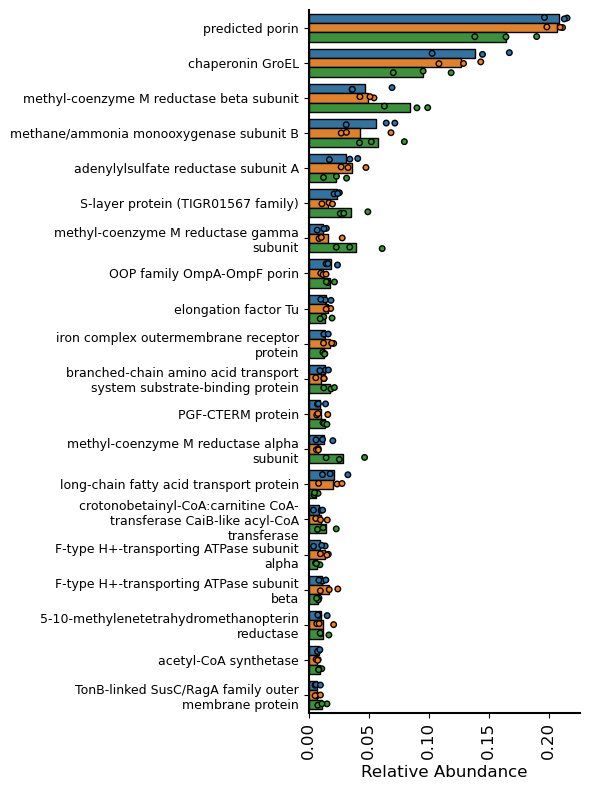

In [19]:
fig, ax = plt.subplots(1,1, figsize=(6, 8))
g = sns.stripplot(data=to_plot_long, y='Gene_Product', x='Normalized_Peak_Height', hue='Depth', hue_order=['0-20cm','20-40cm','40-60cm'], dodge=True, edgecolor='black', linewidth=1, jitter=True, size=4, legend=None)
g = sns.barplot(data=to_plot_long, y='Gene_Product', x='Normalized_Peak_Height', hue='Depth', hue_order=['0-20cm','20-40cm','40-60cm'], dodge=True, edgecolor='black', linewidth=1., errorbar=None, legend=None)

sns.despine()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

labels = ['\n'.join(wrap(x, 40)) for x in  to_plot_long.Gene_Product.drop_duplicates()]
plt.yticks(np.arange(0,20), labels, fontsize=9)

plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Relative Abundance', size=12)
plt.ylabel('')
plt.tight_layout()
plt.savefig('figures/proteomics_geneproduct_abundance.svg', bbox_inches='tight')
plt.show()

### Distance-based analysis of order-level proteomic data

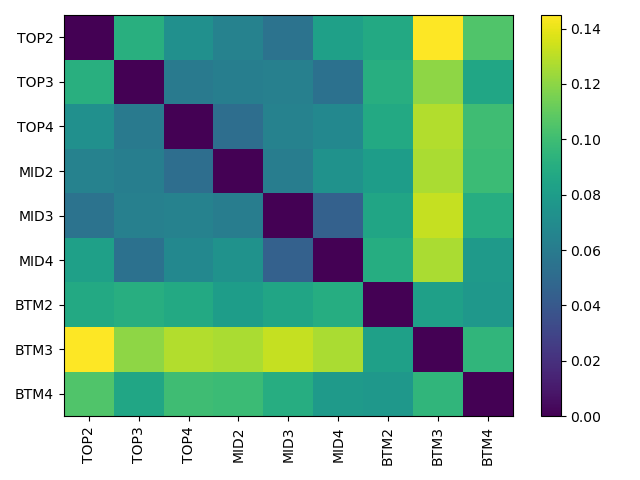

In [56]:
#Calculate distance matrix between samples
dist = pdist(df_imputed.iloc[:,0:9].T, metric='Euclidean')
square_dist = squareform(dist)
dist_mat = distance.DistanceMatrix(square_dist, ids=df_imputed.iloc[:,0:9].columns)
dist_mat

In [53]:
distance.permanova(dist_mat, ['Top','Top','Top','Mid','Mid','Mid','Btm','Btm','Btm'], permutations=99999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                       9
number of groups                  3
test statistic             2.727745
p-value                     0.03321
number of permutations        99999
Name: PERMANOVA results, dtype: object

In [54]:
distance.anosim(dist_mat, ['Top','Top','Top','Mid','Mid','Mid','Btm','Btm','Btm'], permutations=99999)

method name                 ANOSIM
test statistic name              R
sample size                      9
number of groups                 3
test statistic            0.374486
p-value                    0.02504
number of permutations       99999
Name: ANOSIM results, dtype: object

In [58]:
# Compute PCoA
pcoa = ordination.pcoa(dist_mat)
pcoa_plot = pcoa.samples.copy()
pcoa_plot['depth'] = ['Top','Top','Top','Mid','Mid','Mid','Btm','Btm','Btm']

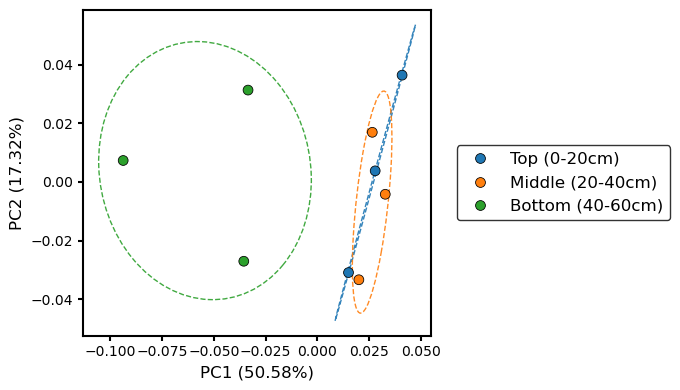

In [59]:
# Plot PCoA of proteomic KO abundance colored by depth
fig, ax = plt.subplots(1,1, figsize=(7, 4))

confidence_ellipse(pcoa_plot[pcoa_plot.depth=='Top']['PC1'], pcoa_plot[pcoa_plot.depth=='Top']['PC2'], ax, edgecolor='tab:blue', linestyle='--', alpha=0.9)
confidence_ellipse(pcoa_plot[pcoa_plot.depth=='Mid']['PC1'], pcoa_plot[pcoa_plot.depth=='Mid']['PC2'], ax, edgecolor='tab:orange', linestyle='--', alpha=0.9)
confidence_ellipse(pcoa_plot[pcoa_plot.depth=='Btm']['PC1'], pcoa_plot[pcoa_plot.depth=='Btm']['PC2'], ax, edgecolor='tab:green', linestyle='--', alpha=0.9)
sns.scatterplot(data=pcoa_plot, x='PC1', y='PC2', hue='depth', s=50, edgecolor='black', hue_order=['Top','Mid','Btm'], ax=ax)

ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)

ax.legend(handles = ax.get_legend_handles_labels()[0][0:3],
          labels=['Top (0-20cm)', 'Middle (20-40cm)', 'Bottom (40-60cm)'],
          fontsize=12, title_fontsize=12, edgecolor='black', bbox_to_anchor=(1.05, 0.61))

ax.tick_params(width=1.5)
plt.xticks(size=10)
plt.yticks(fontsize=10)
plt.xlabel('PC1 ({:.2f}%)'.format(pcoa.proportion_explained.iloc[0]*100), size=12)
plt.ylabel('PC2 ({:.2f}%)'.format(pcoa.proportion_explained.iloc[1]*100), size=12)
plt.tight_layout()
plt.savefig('figures/proteomics_KO_pcoa.png', dpi=450)
plt.show()

## Match proteins function to taxonomic groups

In [20]:
gene_tax_df = df[df.Gene_Product!='hypothetical protein'].groupby('gene-tax').sum().iloc[:,0:9] #add up peak heights for each gene-taxa combo across samples
gene_tax_df[gene_tax_df < 1.] = 0. #replace near-zero values with 0
df_imputed = impute_add_stats(gene_tax_df)

In [21]:
df_imputed.sort_values('median', ascending=False)

,TOP2,TOP3,TOP4,MID2,MID3,MID4,BTM2,BTM3,BTM4,spearman_r,spearman_p,spearman_p_corr,kruskal_p,kruskal_p_corr,median
gene-tax,,,,,,,,,,,,,,,
predicted porin:o__Burkholderiales,0.183521,0.176815,0.168267,0.174621,0.190389,0.188734,1.439846e-01,1.207583e-01,1.482070e-01,-0.579751,0.100956,0.190446,0.050906,0.130074,0.174621
methane/ammonia monooxygenase subunit B:o__Methylococcales,0.027996,0.061534,0.069442,0.068186,0.023850,0.026962,4.758334e-02,5.710144e-02,4.089173e-02,-0.210819,0.550444,0.613186,0.491098,0.721249,0.047583
methyl-coenzyme M reductase beta subunit:o__Methanotrichales,0.051328,0.016836,0.034110,0.049539,0.045854,0.033790,7.740969e-02,9.236612e-02,3.547413e-02,0.527046,0.136436,0.248105,0.288101,0.481465,0.045854
S-layer protein (TIGR01567 family):o__Methanotrichales,0.025528,0.020844,0.023534,0.016885,0.019796,0.009919,4.942011e-02,2.640686e-02,2.938253e-02,0.474342,0.180189,0.310560,0.027324,0.130074,0.023534
PGF-CTERM protein:o__Methanomicrobiales,0.007454,0.014191,0.008116,0.006788,0.007819,0.015993,1.204212e-02,1.311342e-02,1.532412e-02,0.316228,0.371798,0.466227,0.586646,0.746571,0.012042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DNA-directed RNA polymerase subunit beta':o__Anaerolineales,0.000002,0.000004,0.000003,0.000494,0.000001,0.000003,1.174118e-06,1.037808e-06,5.908019e-07,-0.737865,0.036861,0.115105,0.066463,0.130074,0.000002
K(+)-stimulated pyrophosphate-energized sodium pump:o__Bacteroidales,0.000001,0.000491,0.000003,0.000241,0.000001,0.000002,9.810347e-07,1.041947e-06,6.282350e-07,-0.737865,0.036861,0.115105,0.066463,0.130074,0.000001
HSP20 family protein:o__Methanotrichales,0.000001,0.000004,0.000003,0.000002,0.000001,0.000080,9.016563e-07,1.231513e-06,6.483287e-07,-0.737865,0.036861,0.115105,0.066463,0.130074,0.000001


In [22]:
df_imputed.sort_values('spearman_r', ascending=True)

,TOP2,TOP3,TOP4,MID2,MID3,MID4,BTM2,BTM3,BTM4,spearman_r,spearman_p,spearman_p_corr,kruskal_p,kruskal_p_corr,median
gene-tax,,,,,,,,,,,,,,,
acetyl-CoA decarbonylase/synthase complex subunit gamma:o__DSM-27196,0.000332,0.000003,0.000646,0.000002,0.000002,0.000002,1.048018e-06,0.000001,5.453878e-07,-0.948683,0.007288,0.112270,0.027324,0.130074,0.000002
heterodisulfide reductase subunit A:o__Dissulfuribacterales,0.000230,0.000003,0.000003,0.000002,0.000002,0.000002,9.782129e-07,0.000001,6.303058e-07,-0.948683,0.007288,0.112270,0.027324,0.130074,0.000002
heterodisulfide reductase subunit C:o__Methanomicrobiales,0.000188,0.000004,0.000003,0.000003,0.000002,0.000002,9.735739e-07,0.000001,6.561935e-07,-0.948683,0.007288,0.112270,0.027324,0.130074,0.000002
glycerol transport system substrate-binding protein:o__Kiloniellales,0.000688,0.000003,0.001288,0.000003,0.000002,0.000002,1.039356e-06,0.000001,5.679237e-07,-0.948683,0.007288,0.112270,0.027324,0.130074,0.000002
glyceraldehyde 3-phosphate dehydrogenase:o__Oscillospirales,0.000240,0.000003,0.000003,0.000003,0.000002,0.000003,1.091453e-06,0.000001,5.816765e-07,-0.948683,0.007288,0.112270,0.027324,0.130074,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D-xylose transport system substrate-binding protein:o__Desulfobulbales,0.000484,0.000256,0.000241,0.000324,0.001100,0.000310,2.707144e-03,0.001411,3.232065e-03,0.843274,0.017157,0.115105,0.050906,0.130074,0.000484
methanol corrinoid protein:o__Methanomassiliicoccales,0.001282,0.004322,0.001809,0.004158,0.002717,0.004541,8.452714e-03,0.005429,1.191935e-02,0.843274,0.017157,0.115105,0.050906,0.130074,0.004322
uncharacterized membrane protein YheB (UPF0754 family):o__Nannocystales,0.000001,0.000004,0.000003,0.000003,0.000038,0.000019,5.460003e-05,0.000041,2.525536e-04,0.843274,0.017157,0.115105,0.050906,0.130074,0.000019


In [23]:
to_plot = df_imputed.sort_values('median', ascending=False).head(20).iloc[:,0:9]
to_plot_long = to_plot.reset_index().melt(id_vars='gene-tax',var_name='Sample',value_name='Normalized_Peak_Height')
to_plot_long['Depth'] = to_plot_long['Sample'].apply(lambda x:{'TOP':'0-20cm','MID':'20-40cm','BTM':'40-60cm'}[x[0:3]])
to_plot_long

,gene-tax,Sample,Normalized_Peak_Height,Depth
0,predicted porin:o__Burkholderiales,TOP2,0.183521,0-20cm
1,methane/ammonia monooxygenase subunit B:o__Met...,TOP2,0.027996,0-20cm
2,methyl-coenzyme M reductase beta subunit:o__Me...,TOP2,0.051328,0-20cm
3,S-layer protein (TIGR01567 family):o__Methanot...,TOP2,0.025528,0-20cm
4,PGF-CTERM protein:o__Methanomicrobiales,TOP2,0.007454,0-20cm
...,...,...,...,...
175,2-aminobenzoate-CoA ligase:o__Desulfobaccales,BTM4,0.005362,40-60cm
176,adenylylsulfate reductase subunit A:o__Archaeo...,BTM4,0.008266,40-60cm
177,chaperonin GroEL:o__Vicinamibacterales,BTM4,0.013194,40-60cm
178,predicted porin:o__Halothiobacillales,BTM4,0.015686,40-60cm


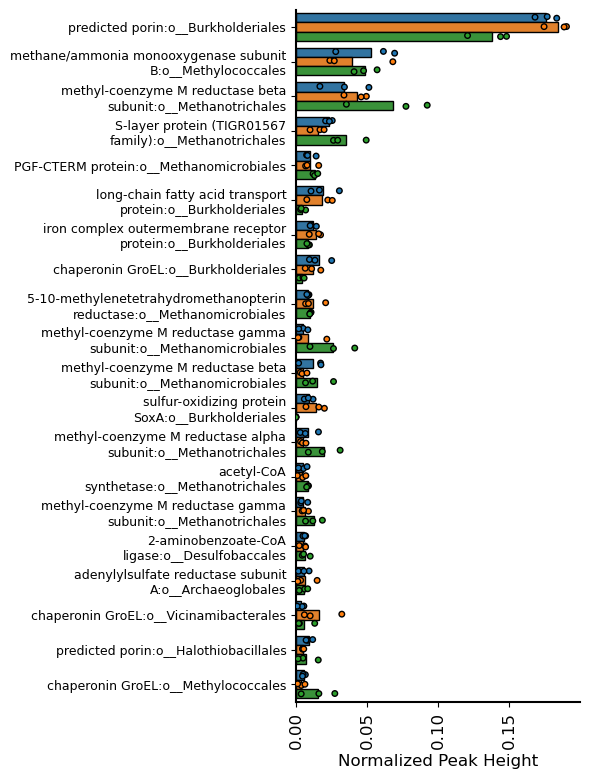

In [24]:
fig, ax = plt.subplots(1,1, figsize=(6, 8))
g = sns.stripplot(data=to_plot_long, y='gene-tax', x='Normalized_Peak_Height', hue='Depth', hue_order=['0-20cm','20-40cm','40-60cm'], dodge=True, edgecolor='black', linewidth=1, jitter=True, size=4, legend=None)
g = sns.barplot(data=to_plot_long, y='gene-tax', x='Normalized_Peak_Height', hue='Depth', hue_order=['0-20cm','20-40cm','40-60cm'], dodge=True, edgecolor='black', linewidth=1., errorbar=None, legend=None)

sns.despine()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

labels = ['\n'.join(wrap(x, 40)) for x in  to_plot_long['gene-tax'].drop_duplicates()]
plt.yticks(np.arange(0,20), labels, fontsize=9)

plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Normalized Peak Height', size=12)
plt.ylabel('')
plt.tight_layout()

### Create heatmap figure

In [25]:
top_orders = list(df.groupby(['gtdb_order_class']).sum()['sum'].sort_values(ascending=False).head(24).index)
top_orders.append('Nitrospiria;Nitrospirales')

In [26]:
# Define which gene products we would like to look at
top_genes = ['F-type H+-transporting ATPase subunit alpha','V/A-type H+-transporting ATPase subunit B','cytochrome c oxidase cbb3-type subunit 2','ubiquinol-cytochrome c reductase cytochrome c1 subunit',
             
             'methyl-coenzyme M reductase alpha subunit','methyl-coenzyme M reductase beta subunit','methyl-coenzyme M reductase gamma subunit',
            'methanol--5-hydroxybenzimidazolylcobamide Co-methyltransferase','methanol corrinoid protein','5-10-methylenetetrahydromethanopterin reductase',
             
             
             'acetyl-CoA synthetase','acetyl-CoA decarbonylase/synthase complex subunit beta','acetyl-CoA synthase','carbon-monoxide dehydrogenase catalytic subunit','ribulose-bisphosphate carboxylase large chain',
             
             'coenzyme F420 hydrogenase subunit gamma','F420-non-reducing hydrogenase iron-sulfur subunit','[NiFe] hydrogenase large subunit','bidirectional [NiFe] hydrogenase diaphorase subunit','NADP-reducing hydrogenase subunit HndC',
             
             'methane/ammonia monooxygenase subunit B','PQQ-dependent dehydrogenase (methanol/ethanol family)','alcohol dehydrogenase','alcohol dehydrogenase (cytochrome c)',

             'formate dehydrogenase subunit beta','formate dehydrogenase major subunit','malate dehydrogenase','glycerol kinase','glyceraldehyde 3-phosphate dehydrogenase','aldehyde:ferredoxin oxidoreductase',

             '2-aminobenzoate-CoA ligase','6-oxo-cyclohex-1-ene-carbonyl-CoA hydrolase','crotonobetainyl-CoA:carnitine CoA-transferase CaiB-like acyl-CoA transferase',
             
            'sulfate adenylyltransferase','adenylylsulfate reductase subunit A','sulfite reductase alpha subunit','sulfite reductase beta subunit',
            'sulfur-oxidizing protein SoxA','sulfide dehydrogenase [flavocytochrome c] flavoprotein subunit',
             
             
             'nitrate reductase beta subunit','nitrate reductase NapA','nitrite reductase (NO-forming)/hydroxylamine reductase','nitrite reductase (cytochrome c-552)','nitric oxide reductase NorD protein','nitrous-oxide reductase',
             
             
            'long-chain fatty acid transport protein','iron complex outermembrane receptor protein','outer membrane receptor protein involved in Fe transport','branched-chain amino acid transport system substrate-binding protein',
            'peptide/nickel transport system substrate-binding protein','maltoporin','D-xylose transport system substrate-binding protein',
            'multiple sugar transport system ATP-binding protein','TRAP-type mannitol/chloroaromatic compound transport system substrate-binding protein']
top_genes_labels = ['F-type ATPase','V/A-type ATPase','Cytochrome c, cbb3-type','Cytochrome bc1',
                    
                    'McrA','McrB','McrG','MtaB','MtaC','Mer',
                    
                    'Acs','CdhC','AcsB','CooS/AcsA','RuBisCO',
                    
                    'FrhG','MvhD','HydB','HoxF','HndC',
                    
                    'MmoB/AmoB','Methanol dehydrogenase','Adh (YiaY)','Adh (ExaA)',
                    'Fdh (F420)','Fdh (NAD+)','Mdh','GlpK','GapA','Aor',

                    'abmG','Oah','CaiB',
                    
                    'Sat','AprA','DsrA','DsrB','SoxA','FccB',
                    
                    
                     'NarH/NxrB','NapA','NirS','NrfA','NorD','NosZ',
                    
                    
                    'Long-chain fatty acid','Fe(III)-hydroxamate','Fe(III)-catecholate','Branched-chain amino acid',
                    'Peptide/nickel','Maltoporin','D-xylose',
                    'Multiple sugar','Mannitol/chloroaromatics']
label_dict = dict(zip(top_genes, top_genes_labels))

In [27]:
# Print gene product names and abbreviations
for i in label_dict:
    print(i+' ('+label_dict[i]+')')

F-type H+-transporting ATPase subunit alpha (F-type ATPase)
V/A-type H+-transporting ATPase subunit B (V/A-type ATPase)
cytochrome c oxidase cbb3-type subunit 2 (Cytochrome c, cbb3-type)
ubiquinol-cytochrome c reductase cytochrome c1 subunit (Cytochrome bc1)
methyl-coenzyme M reductase alpha subunit (McrA)
methyl-coenzyme M reductase beta subunit (McrB)
methyl-coenzyme M reductase gamma subunit (McrG)
methanol--5-hydroxybenzimidazolylcobamide Co-methyltransferase (MtaB)
methanol corrinoid protein (MtaC)
5-10-methylenetetrahydromethanopterin reductase (Mer)
acetyl-CoA synthetase (Acs)
acetyl-CoA decarbonylase/synthase complex subunit beta (CdhC)
acetyl-CoA synthase (AcsB)
carbon-monoxide dehydrogenase catalytic subunit (CooS/AcsA)
ribulose-bisphosphate carboxylase large chain (RuBisCO)
coenzyme F420 hydrogenase subunit gamma (FrhG)
F420-non-reducing hydrogenase iron-sulfur subunit (MvhD)
[NiFe] hydrogenase large subunit (HydB)
bidirectional [NiFe] hydrogenase diaphorase subunit (HoxF)
N

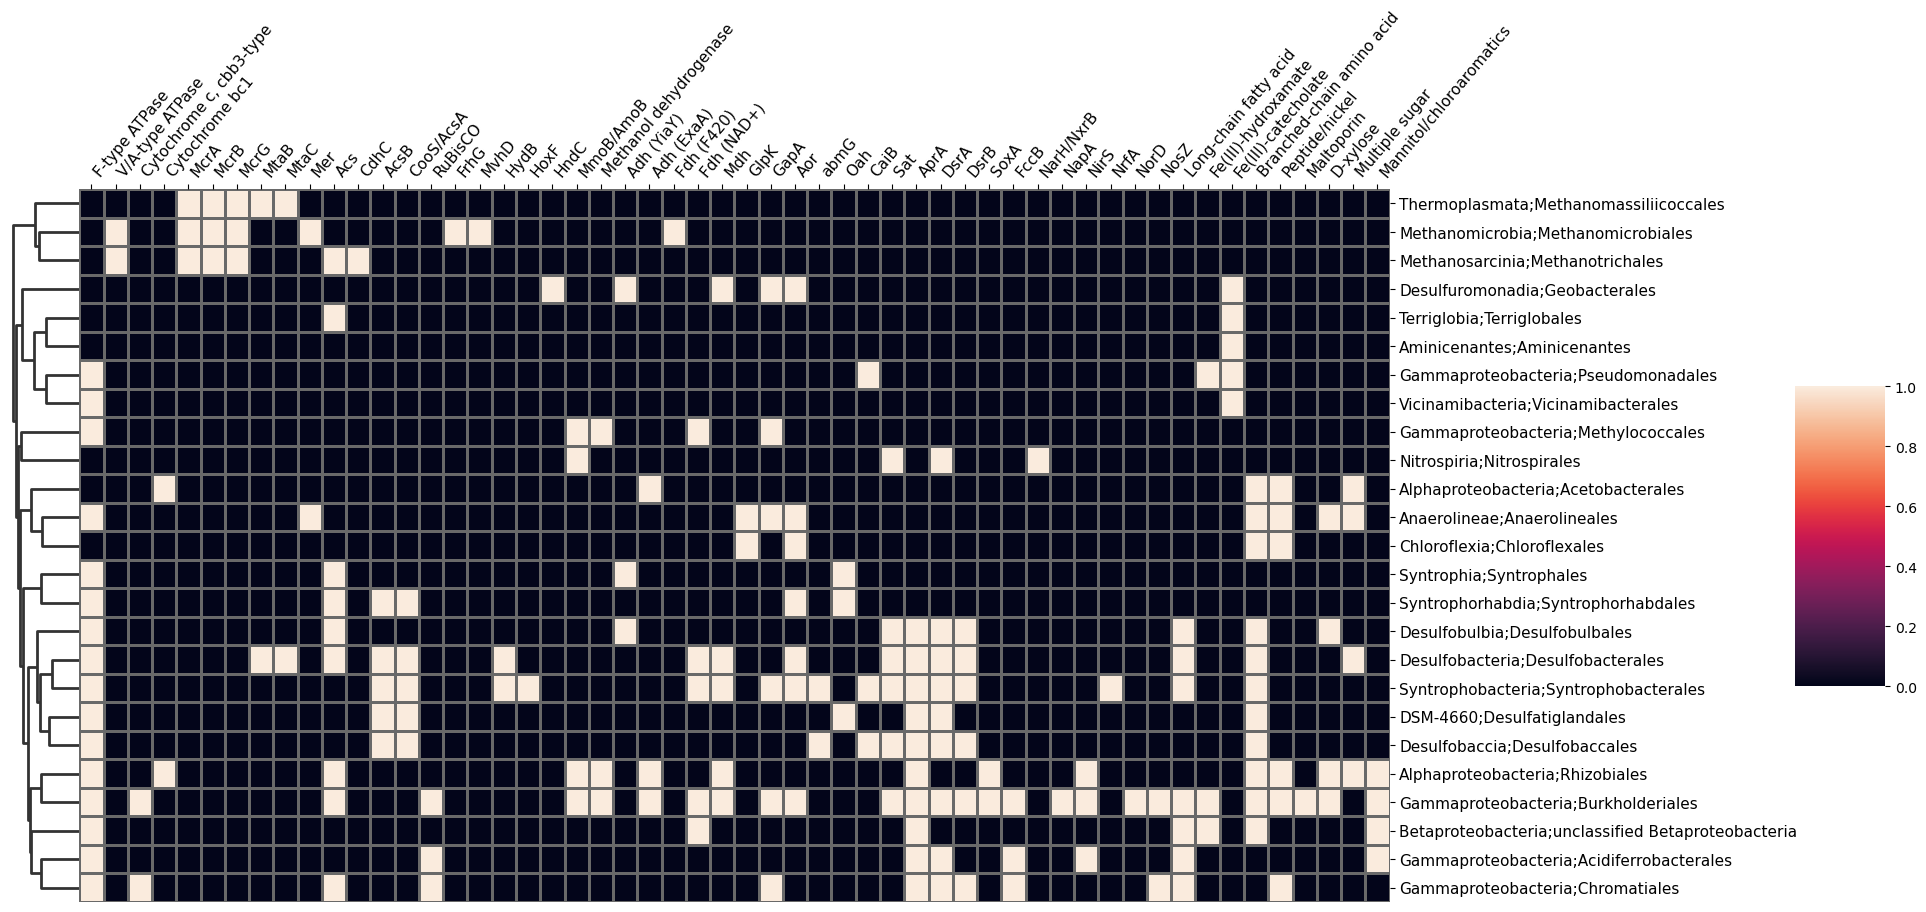

In [28]:
# Create heatmap figure
heatmap_df = pd.DataFrame(df[(df['gtdb_order_class'].isin(top_orders))&(df['Gene_Product'].isin(top_genes))].groupby(['gtdb_order_class','Gene_Product']).sum()['sum']
                            ).reset_index().pivot(columns='Gene_Product', index='gtdb_order_class', values='sum')
heatmap_df.rename({'unclassified Candidatus Aminicenantes;unclassified Candidatus Aminicenantes':'Aminicenantes;Aminicenantes'}, inplace=True)
heatmap_df = (heatmap_df > 0).astype(int)
heatmap_df = heatmap_df.fillna(0.)
ax = sns.clustermap(heatmap_df[top_genes], col_cluster=False, row_cluster=True, standard_scale=0, vmax=1., 
               linewidths=2., linecolor='dimgray', figsize=(18,10),  cbar_pos=(1., 0.45, 0.05, 0.3), 
                    xticklabels=[label_dict[i] for i in top_genes],
                dendrogram_ratio=0.05, tree_kws={'linewidths': 2}, metric='Jaccard')
ax.ax_heatmap.tick_params(labelsize=11)
ax.ax_heatmap.xaxis.tick_top()
ax.ax_heatmap.yaxis.tick_right()
ax.ax_heatmap.set_xlabel('')
ax.ax_heatmap.set_ylabel('')

for label in ax.ax_heatmap.get_xticklabels():
    label.set_rotation(50)  # Set rotation
    label.set_horizontalalignment('left')  # Align horizontally

plt.savefig('figures/proteomics_heatmap.svg', bbox_inches='tight')

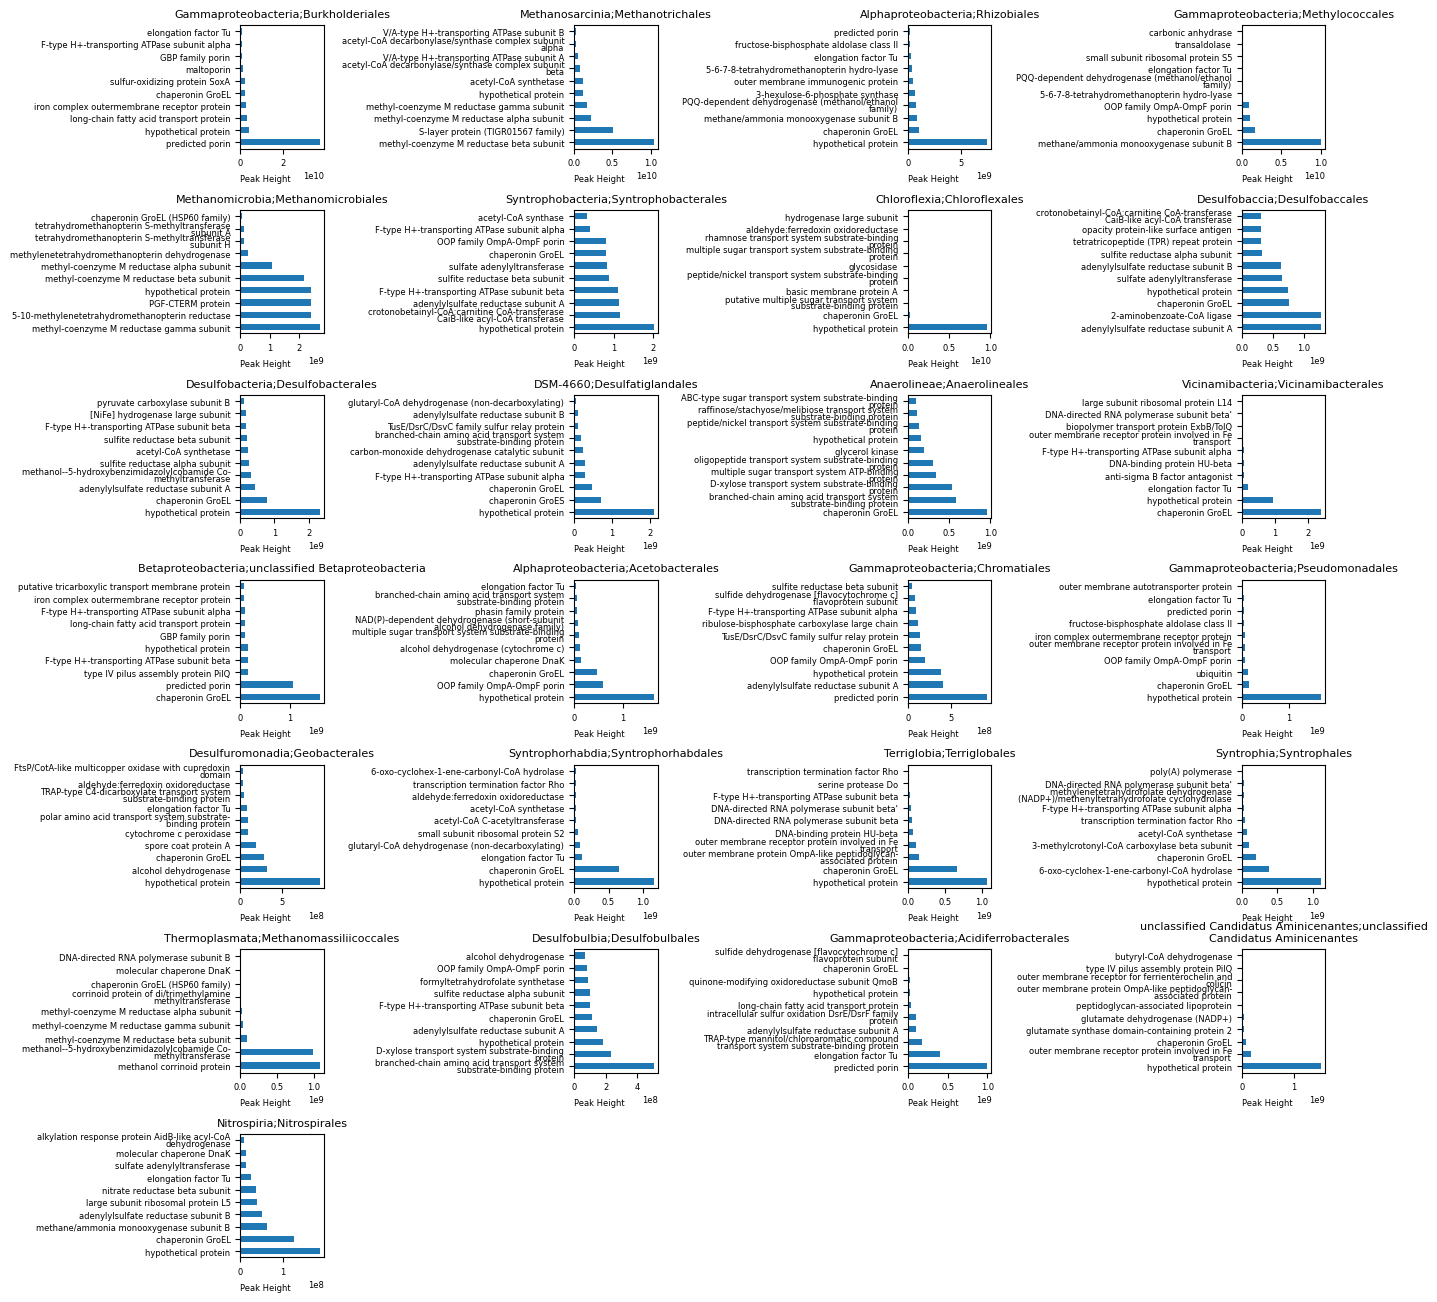

In [29]:
# Create faceted plot for each order showing top identified proteins
fig, ax = plt.subplots(7,4,figsize=(14,16))
ax = ax.flatten()
for i, order in enumerate(top_orders):
    df[df['gtdb_order_class']==order].groupby('Gene_Product').sum()['sum'].sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[i])
    ax[i].set_title('\n'.join(wrap(order, 50)), fontsize=8)
    ax[i].set_xlabel('Peak Height', loc='left', labelpad=5, fontsize=6)
    ax[i].set_ylabel('')
    ax[i].tick_params(axis='both', labelsize=6)
    ax[i].xaxis.get_offset_text().set_size(6)
    ax[i].xaxis.get_offset_text().set_ha('right')
    labels = ['\n'.join(wrap(x.get_text(), 50)) for x in  ax[i].get_yticklabels()]
    ax[i].set_yticklabels(labels=labels, linespacing=0.7)

for i in range(len(top_orders), len(ax)):
    ax[i].axis('off')

plt.subplots_adjust(wspace=3., hspace=0.5)
plt.savefig('figures/proteomics_orders_separate_plots.svg')
plt.show()
